# Programmieraufgaben zur 2. Sonderübung

## Aufgabe 1
In dieser Aufgabe sollen Sie die Performance des Gradientenverfahrens (aus der letzten Sonderübung) mit dem Gauß-Newton Verfahren vergleichen.

In [1]:
import numpy as np
from numpy.linalg import *
import time

### Die Zielfunktion
Implementieren Sie je eine Funktion für den Funktionswert und eine für den Gradienten von NLS

In [2]:
def r_jac(x):
    r_jac = np.array([[-20*x[0], 10 ],[-1, 0]])
    
    return r_jac
    
def h(x):
    h_val = 50*(x[1]-x[0]**2)**2+ 0.5* (1 - x[0])**2
    return h_val

def h_grad(x):
    """
    Gradient of Rosenbrock function
    """
    h_grad = np.array([-200*x[0]*(x[1] - x[0]**2) + x[0] - 1, 100*(x[1] - x[0]**2)])
    ...
    
    return h_grad

### 3d Plot der Zielfunktion

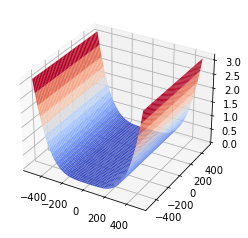

In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.arange(-500,500,0.25)
y = np.arange(-500,500,0.25)
X,Y = np.meshgrid(x,y)
Z = h([X,Y])
plot = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
plt.show()

### Höhenlinienplot der Zielfunktion
Plotten sie mit `plt.contour` die vorgegebenen Höhenlinien der Zielfunktion.

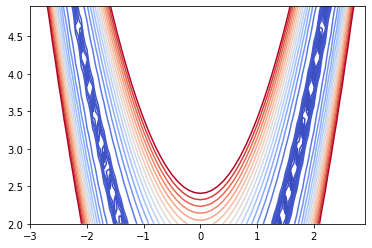

In [107]:
x2 = np.arange(-3,3,0.1)
y2 = np.arange(2,5,0.1)
X2,Y2 = np.meshgrid(x2,y2)
Z2 = h([X2,Y2])
levels = np.hstack((np.arange(0,0.9,0.1),np.arange(1,9,1),np.arange(10,300,20)))
fig2 = plt.figure()
ax2 = plt.axes()
ax2.contour(X2,Y2,Z2,levels,cmap=cm.coolwarm)
plt.show()

### Das Gradientenverfahren
Benutzen Sie hierfür die Implementierung aus der 1. Sonderübung (falls Sie nicht teilgenommen haben, ist die Vorlage hier gegeben).

In [5]:
def gradientDescent(obj_fun , grad_fun , line_search, x_0, epsilon):

    """ classical gradient descent
    
    Input
    ----------
    
    obj_fun: callable
        Objective function to be mimimized.
            Input: ndarray, 
            Output: float
        
    grad_fun: callable
        Gradient of objective function.
            Input: ndarray, 
            Output: ndarray, 
    
    line_search: callable
        Line-search procedure to be used in the algorithm.
            Input: x: ndarray
                    Starting point of the method.
                   d: ndarray
                    Starting direction of the method (negative gradient). 
            Output: float
        
    x_0: ndarray
        Starting point of the method.
       
    epsilon: float
        Tolerance for the termination of the method.
        
        
    Output
    -------
    
    x_crit: ndarray
        Approx. of a critical point of the objective function.
    
    f_crit: float
        Objective value at x_opt
        
    k: int
        Number of iterations.
        
    runtime: float
        Runtime of the algorithm.
    
    """
    
    start_time = time.time()
    k = 0
    x = x_0
    f_grad = grad_fun(x) # Gradienten von f an x auswerten
    d = -1 * f_grad # Suchrichtung ergänzen
    while (np.linalg.norm(f_grad)) > epsilon: # Abbruchkriterium ergänzen
        t = line_search(x,d) # Schrittweite bestimmen
        x = x + t*d # Update der aktuellen Iterierten
        f_grad = grad_fun(x) # Gradient von f an neuer Iterierter
        d = -1* f_grad # Suchrichtung ergänzen
        k += 1
    x_crit = x # Approximation eines kritischen Punktes
    f_crit = obj_fun(x) # Zielfunktionswert an der Approximation
    runtime = time.time() - start_time # Laufzeit des Verfahrens
    return x_crit, f_crit, k, runtime
#

### Schrittweitensteuerung
Nutzen Sie die in der letzten Sonderübung implementierte Armijo-Regel (falls Sie nicht teilgenommen haben, befindet sich hier eine Vorlage), passen Sie diese gegebenenfalls so an, dass sie sowohl vom Gradientenverfahren, als auch vom Gauß-Newton Verfahren aufgerufen werden kann.

In [19]:
def armijo(x, d, obj_fun, grad_fun, sigma, rho, gamma):
    
    """ Armijo stepzise rule
    
    Parameters
    ----------  
    x: ndarray - Current iterate of the optimization algorithm.
        
    d: ndarray - Search direction.
    
    obj_fun: callable - Objective function to be mimimized. Returns a number.
        
    grad_fun: callable - Gradient of objective function, returns a vector.
       
    sigma: float - Parameter that determines flatness of damped tangent. (0<sigma<1)
    
    rho: float - Parameter that determines how fast stepsize is decreaded. (0<rho<1)
        
    gamma: float - Parameter that determines appropriate starting stepsize.
        
    Returns
    -------
    t: float - Armijo stepsize.
    
    """
    
    f_value = obj_fun(x) # Funktionswert am Punkt x auswerten
    t =  -1 * gamma * (grad_fun(x) @ d)/(np.linalg.norm(d)**2)  # Start-Schrittweite (t_0 in Algorithmus 2.4)
    x_trial = x + t * d # Schritt in Richtung d mit Schrittweite t
    f_trial = obj_fun(x_trial) # Funktionswert am Punkt x_trial
    while f_trial > (f_value + t * sigma * (grad_fun(x)@d)): # Abbruchkriterium ergänzen:
        t = rho * t # Schrittweite updaten
        x_trial = x + t * d # Schritt in Richtung d mit neuer Schrittweite t
        
        f_trial = obj_fun(x_trial) # Funktionswert am neuen Punkt x_trial
        
    if np.linalg.norm(t*d) < 10**(-14):
        t = 10**(-7)
        
    return t

### Das Gauß-Newton-Verfahren
Implementieren Sie hier das Gauß-Newton-Verfahren. Orientieren Sie sich hierbei an Algorithmus 2.6 und den Angaben auf S.87 im Buch 

In [11]:
def gaussnewton_method(h_val, h_grad, r_jac, x_start, line_search, tol):
    
    """ Gauss-Newton-Method
    
    Parameters
    ----------
    h_val: callable - function value of nonlinear least squares problem
            Input: x: ndarray
            Output h_val: float
            
    h_grad: callable - gradient of nonlinear least squares problem

    r_jac: callable -  Jacobian of inner function
        
    x_start: ndarray - start iterate of the optimization algorithm.
        
    line_search: callable - Line-search procedure to be used in the algorithm.
    
    tol: float -  tolerance parameter for stopping rule
        
        
    Returns
    ------- 
    x_crit: ndarray - Approx. of a critical point of the objective function.
    
    f_crit: float - Objective value at x_crit
        
    k: int - Number of iterations.
        
    runtime: float - Runtime of the algorithm.
    
    """
    start_time = time.time()
    k = 0
    x = x_start
    grad = h_grad(x) # Gradienten von h an x auswerten
    A = np.transpose(r_jac(x)) @ r_jac(x)
    d = -1 * np.linalg.inv(A) @  grad # Suchrichtung ergänzen
    while (np.linalg.norm(grad)) > tol: # Abbruchkriterium ergänzen
        t = line_search(x,d) # Schrittweite bestimmen
        x = x + t*d # Update der aktuellen Iterierten
        grad = h_grad(x) # Gradient von f an neuer Iterierter
        A = np.transpose(r_jac(x)) @ r_jac(x)
        d = -1* np.linalg.inv(A) @ grad # Suchrichtung ergänzen
        k += 1
    x_crit = x # Approximation eines kritischen Punktes
    f_crit = h_val(x) # Zielfunktionswert an der Approximation
    runtime = time.time() - start_time # Laufzeit des Verfahrens
    return x_crit, f_crit, k, runtime

### Ausführung beider Verfahren

Zunächst sollte erneut ein Handle für die Armijo-Regel mit der lambda-Notation und die dafür notwendigen Parameter definiert werden.

In [8]:
sigma = 0.5
rho = 0.4
gamma = 1
armijo_rule = lambda x, d: armijo(x, d, h, h_grad, sigma, rho, gamma)

Fügen Sie hier die Implementierung vom Gradientenverfahren aus der letzten Sonderübung ein

In [9]:
x_0 = np.array([2,5])
tol = 10**(-4)

Führen Sie nun beide Verfahren mit der Startpunkt $x^0 = (2,5)^\top$ und der Toleranz $\varepsilon = 10^{-4}$ aus.

In [20]:
x_crit, f_crit, k, runtime =  gradientDescent(h , h_grad , armijo_rule, x_0, tol)
x_crit2, f_crit2, k2, runtime2 = gaussnewton_method(h, h_grad, r_jac, x_0, armijo_rule, tol)

Diskutieren Sie die Ergebnisse:

In [21]:
print(x_crit)
print(f_crit)
print(h_grad(x_crit))
print(k)
print(runtime)
print("-----------------------------------")
print(x_crit2)
print(f_crit2)
print(h_grad(x_crit2))
print(k2)
print(runtime2)

[1.00021968 1.0004402 ]
2.4160990123469968e-08
[5.99829638e-05 7.98297862e-05]
8490
1.4201250076293945
-----------------------------------
[1.00000254 1.00000468]
1.1304545981398824e-11
[ 8.29474272e-05 -4.02042329e-05]
18
0.001622915267944336


Beide Verfahren konvergieren gegen dasselbe lokale Minimum -> das Gaus-Newton Verfahren allerdings sehr viel schneller (18 vs 8490 Iterationsschritte)

## Aufgabe 2
### Hintergrund und Daten

Der in dieser Aufgabe verwendete Datensatz heißt MNIST und stammt von dieser Website: http://yann.lecun.com/exdb/mnist/.

Die Datei <b>mnist_data.npz</b> enthält die Matrizen $X\in\mathbb{R}^{60000\times 784}$, $Y\in\mathbb{R}^{60000\times 10}$, $X_t\in\mathbb{R}^{10000\times 784}$ und $Y_t\in\mathbb{R}^{10000\times 10}$. 

Die Matrizen $X$ und $Y$ enthalten den Datensatz, den Sie in Teilaufgabe a) verwenden sollen. In den Zeilen der Matrix $X$ stehen die Vektoren $x^i$. In den Zeilen von $Y$ sind die zugehörige Vektoren $y^i$ gespeichert. Dieser Datensatz besteht also aus $n=60000$ Datenpunkten.

Die Matrizen $X_t\in\mathbb{R}^{10000\times 784}$ und $Y_t\in\mathbb{R}^{10000\times 10}$ enthalten den Test-Datensatz, den Sie in Teilaufgabe b) verwenden sollen. Es gilt ganz analog: In den Zeilen der Matrix $X_t$ stehen die Test-Vektoren $x^i_t$. In den Zeilen von $Y_t$ sind die zugehörige Vektoren $y^i_t$ gespeichert. Der Test-Datensatz besteht also aus $10000$ Datenpunkten.

Der Datensatz kann folgendermaßen geladen werden:

In [15]:
import numpy as np

data = np.load("mnist_data.npz")
X = data['X']
Y = data['Y']
X_t = data['X_t']
Y_t = data['Y_t']

Die mit den Vektoren $x^i$ kodierten Bilder können sehr einfach visualisiert werden. Wir schauen uns exemplarisch die 111. Zahl an:

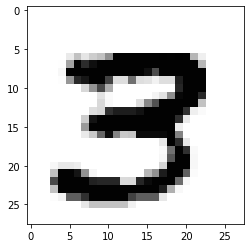

In [16]:
import matplotlib.pyplot
%matplotlib inline

i = 111
plot_array = X[i,:].reshape((28,28))
matplotlib.pyplot.imshow(plot_array, cmap='Greys', interpolation='None')

Im zugehörigen Vektor $y^i$ ist die Information gespeichert, dass es sich um die Ziffer 3 handelt.

In [17]:
Y[i,:]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

### Die Funktionen in MLP.py
In der Python-Datei <b>MLP.py</b> finden Sie die Python-Funktionen <b>F</b>, <b>F-gradient</b> und <b>h</b>, welche die Zielfunktion $F$, ihren Gradienten $\nabla F$ und die Prognosefunktion $h$ implementieren. (Sie müssen diese also nicht selbst implementieren.)

Damit Sie die Python-Funktionen in der Datei <b>MLP.py</b> in diesem Jupyter-Notebook verwenden können, importieren wir die Inhalte der Datei.

In [56]:
from MLP import F,F_gradient
from MLP import h as pred

Beachten Sie: Wir minimieren die Zielfunktion <b>F</b> für einen festen Trainingsdatensatz über die Parameter des neuronalen Netzes. Das heißt, in einem Lösungsverfahren werden <b>F</b> und <b>F-gradient</b> immer für verschiedene Parameter-Vektoren $w\in \mathbb{R}^d$ ausgewertet, der Trainingsdatensatz, bestehend aus <b>X</b> und <b>Y</b>, ist fest. 

Passen Sie daher die Aufrufstruktur mithilfe von lambda-Funktionen an. <b>(1 Punkt)</b>

In [42]:
function = lambda w: F(w,X,Y)
gradient = lambda w: F_gradient(w, X, Y)

### Optimierung mit dem Gradientenverfahren 

Fügen Sie hier den Code für das Gradientenverfahren mit Armijo-Schrittweitensteuerung erneut ein. Die Parameter $\sigma$, $\rho$ und $\gamma$ können wie zuvor gewählt werden.

Beachten Sie, dass in dieser Anwendung die Auswertung des Gradienten und der Zielfunktion recht aufwändig ist. Passen Sie die Methoden daher so an, dass möglichst wenige Auswertungen benötigt werden.

Ergänzen Sie ein Zeitlimit, das dem Gradientenverfahren übergeben wird. Die Ausführung der while-Schleife wird beendet, wenn das Zeitlimit überschritten wird. Die Länge des Gradienten von F soll für den Abbruch des Verfahrens keine Rolle spielen. <b>(1 Punkt)</b>

In [28]:
def armijo_gd(x, d, obj_fun, sigma, rho, gamma):
    
    """ Armijo stepzise rule
    
    Parameters
    ----------  
    x: ndarray - Current iterate of the optimization algorithm.
        
    d: ndarray - Search direction.
    
    obj_fun: callable - Objective function to be mimimized. Returns a number.
        
    grad_fun: callable - Gradient of objective function, returns a vector.
       
    sigma: float - Parameter that determines flatness of damped tangent. (0<sigma<1)
    
    rho: float - Parameter that determines how fast stepsize is decreaded. (0<rho<1)
        
    gamma: float - Parameter that determines appropriate starting stepsize.
        
    Returns
    -------
    t: float - Armijo stepsize.
    
    """
    
    f_value = obj_fun(x) # Funktionswert am Punkt x auswerten
    t =  gamma  # Start-Schrittweite (t_0 in Algorithmus 2.4)
    x_trial = x + t * d # Schritt in Richtung d mit Schrittweite t
    f_trial = obj_fun(x_trial) # Funktionswert am Punkt x_trial
    while f_trial > (f_value - t * sigma * (np.linalg.norm(d)**2)): # Abbruchkriterium ergänzen:
        t = rho * t # Schrittweite updaten
        x_trial = x + t * d # Schritt in Richtung d mit neuer Schrittweite t
        
        f_trial = obj_fun(x_trial) # Funktionswert am neuen Punkt x_trial
        
    if np.linalg.norm(t*d) < 10**(-14):
        t = 10**(-7)
        
    return t

In [46]:
sigma = 0.5
rho = 0.4
gamma = 1
armijo_rule_gd = lambda d,x: armijo_gd(x, d, function, sigma, rho, gamma)

In [36]:
def gradientDescent_stoch(obj_fun , grad_fun , line_search, x_0, epsilon,rt):

    """ classical gradient descent
    
    Input
    ----------
    
    obj_fun: callable
        Objective function to be mimimized.
            Input: ndarray, 
            Output: float
        
    grad_fun: callable
        Gradient of objective function.
            Input: ndarray, 
            Output: ndarray, 
    
    line_search: callable
        Line-search procedure to be used in the algorithm.
            Input: x: ndarray
                    Starting point of the method.
                   d: ndarray
                    Starting direction of the method (negative gradient). 
            Output: float
        
    x_0: ndarray
        Starting point of the method.
       
    epsilon: float
        Tolerance for the termination of the method.
        
        
    Output
    -------
    
    x_crit: ndarray
        Approx. of a critical point of the objective function.
    
    f_crit: float
        Objective value at x_opt
        
    k: int
        Number of iterations.
        
    runtime: float
        Runtime of the algorithm.
    
    """
    
    start_time = time.time()
    k = 0
    x = x_0
    f_grad = grad_fun(x) # Gradienten von f an x auswerten
    d = -1 * f_grad # Suchrichtung ergänzen
    while (time.time() - start_time) < rt: # Abbruchkriterium ergänzen
        t = line_search(x,d) # Schrittweite bestimmen
        x = x + t*d # Update der aktuellen Iterierten
        f_grad = grad_fun(x) # Gradient von f an neuer Iterierter
        d = -1* f_grad # Suchrichtung ergänzen
        k += 1
    x_crit = x # Approximation eines kritischen Punktes
    f_crit = obj_fun(x) # Zielfunktionswert an der Approximation
    runtime = time.time() - start_time # Laufzeit des Verfahrens
    return x_crit, f_crit, k, runtime
#

### Startpunkte und Aufruf der Methode

Das Verfahren muss mehrfach mit zufälligen Startpunkten $w^0 \in \mathbb{R}^d$ gestartet werden. Für die Vergleichbarkeit der Ergebnisse ist es wichtig, dass alle 3er-Gruppen den Seed des Zufallszahlengenerators auf den gleichen Wert setzen und alle Einträge des Startpunktes aus einer Normalverteilung mit Erwartungswert 0 und Standardabweichung 0.05 ziehen. Erzeugen Sie Ihre Startpunkte deshalb folgendermaßen:

In [44]:
w_0 = np.zeros([10,79510])              # "Platzhalter", Startvektoren Nr. i steht in der i-ten Zeile von w_0
np.random.seed(123)                     # Setzt den Seed des Zufallszahlengenerators auf 123
for k in range(10):                     # 10 Durchläufe
    w_0[k,:] = 0.05 * np.random.randn(79510) # Ein neuer "zufälliger" Startpunkt für jeden Durchlauf

Berechnen Sie für die 10 zufälligen Startpunkte eine Approximation eines kritischen Punktes der Funktion F mithilfe des zuvor beschriebenen Gradientenverfahrens. Für jeden Startpunkt soll das Verfahren L=240 Sekunden laufen. Geben Sie das arithmetische Mittel und die Standardabweichung der Zielfunktionswerte der berechneten Punkte an. <b>(5 Punkte)</b>

In [49]:
w = np.zeros([10,79510])
val = np.zeros(10)
k = np.zeros(10)
t = np.zeros(10)
for i in range(10):
    w[i,:],val[i],k[i],t[i] = gradientDescent_stoch(function , gradient , armijo_rule_gd, w_0[i], tol,240)

[[-5.38107753e-12 -4.75867262e-12  1.15243752e-12 ... -3.90520277e-09
   2.03220339e-08 -7.00273607e-09]
 [-1.31412242e-12  5.20051927e-12  1.38518363e-12 ... -3.86489396e-09
  -1.86841121e-08  1.25079531e-09]
 [ 5.86961035e-14 -1.38791756e-13  2.25149760e-13 ...  5.51926262e-10
  -8.99564125e-10  2.39791771e-09]
 ...
 [ 2.60516175e-12  3.81326221e-12  3.03154030e-12 ... -4.56715791e-09
  -1.47770061e-08  2.59713135e-08]
 [-7.95465430e-12 -1.06167158e-11 -1.32581168e-11 ... -1.58005824e-08
   1.56613502e-08 -5.15402338e-09]
 [-2.22211659e-12 -3.02973792e-12  9.72243119e-13 ... -6.10782932e-09
  -2.49454811e-09  4.47369745e-10]]


### Auswertung der Ergebnisse

Nun sollen Sie die Frage beantworten, wie viel Prozent der Bilder des Test-Datensatzes (<b>$X_t$, $Y_t$</b>) im Mittel korrekt erkannt werden, wenn die Prognosefunktionen verwendet werden, die sich aus den mit dem jeweiligen Verfahren berechneten Punkten ergeben. Was heißt in diesem Kontext "korrekt erkannt"? 

Ein Beispiel: Seien $x\in\mathbb{R}^{784}$ ein Punkt des Test-Datensatzes und $y$ das zugehörige Label. Dann sagen wir, dass das Bild $x$ bei Wahl des Punktes/Parameters $w\in\mathbb{R}^d$ (aus der vorigen Aufgabe!) korrekt erkannt wird, wenn der Index des größten Eintrags des Vektors $h(x;w)$ mit dem einzigen Nicht-Null-Eintrag von $y$ übereinstimmt, d.h. für $i\in\arg\!\max h(x;w)$ muss $y_i=1$ gelten.

Wenn Sie die Funktion $h$ mit

In [69]:
Y_pred = pred(w[3], X_t)

aufrufen, enthält die Matrix <b>Y_pred</b> die Vorhersagen für jeden Punkt des Test-Datensatzes bei Wahl des Parameters <b>w</b>. Sie müssen diese Matrix dann wie oben beschrieben mit der gegebenen Matrix <b>Y_t</b> abgleichen, um herauszufinden, wie viel Prozent der Vorhersagen zutreffen. Dies wiederholen Sie dann für jeden der zuvor berechneten Parametervektoren. Berechnen Sie anschließend das arithmetische Mittel und die empirische Standardabweichung der Ergebnisse <b>(4 Punkte)</b>

<i> Falls Sie in Teilaufgabe a keine Approximationen für kritische Punkte berechnen konnten, dürfen Sie die Kennzahlen für die zufälligen Startvektoren berechnen </i> 

In [98]:
accuracy = np.zeros(10)
for i in range(10):
    Y_pred = pred(w[i], X_t)
    guess = np.argmax(Y_pred, axis = 1)
    right = np.argmax(Y_t, axis = 1) 
    accuracy[i] = sum(guess == right)/10000


In [104]:
print(np.mean(accuracy))
print(np.std(accuracy))

0.10533
0.01230545001208814


<i>Hinweis zur Abgabe: Laden Sie bitte nicht die Datei `mnist_data.npz` bei der Abgabe wieder mit hoch.